Importing the Basic Libraries 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import optuna 
import missingno as msno

Importing the EWQI data

In [2]:
ewqi_data = pd.read_csv('./quality_estimate_and_entropy_wqi.csv')
ewqi_data.head()

,PH,EC,TDS,ALK,TH,F,CL,NO3,SO4,CA,MG,qi_wi,EWQI,EWQI_CLASSIF
0,83.333333,1696.666667,341.0,608.333333,150.000000,186.666667,383.6,53.333333,138.4,106.666667,200.000000,307.655924,307.655924,Unsuitable
1,82.000000,4736.666667,952.1,691.666667,433.333333,442.666667,1349.2,3555.555556,516.0,240.000000,690.000000,1274.533598,1274.533598,Unsuitable
2,78.000000,228.333333,45.9,208.333333,73.333333,29.333333,20.0,4.444444,0.8,69.333333,73.333333,59.095708,59.095708,Poor
3,79.333333,3553.333333,714.2,675.000000,266.666667,746.666667,994.0,71.111111,177.2,186.666667,363.333333,636.424848,636.424848,Unsuitable
4,68.666667,433.333333,87.1,208.333333,93.333333,33.333333,34.0,511.111111,68.4,85.333333,96.666667,151.448314,151.448314,Unsuitable


# EDA 

In [3]:
ewqi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PH            2764 non-null   float64
 1   EC            2764 non-null   float64
 2   TDS           2764 non-null   float64
 3   ALK           2764 non-null   float64
 4   TH            2764 non-null   float64
 5   F             2764 non-null   float64
 6   CL            2764 non-null   float64
 7   NO3           2764 non-null   float64
 8   SO4           2764 non-null   float64
 9   CA            2764 non-null   float64
 10  MG            2764 non-null   float64
 11  qi_wi         2764 non-null   float64
 12  EWQI          2764 non-null   float64
 13  EWQI_CLASSIF  2764 non-null   object 
dtypes: float64(13), object(1)
memory usage: 302.4+ KB


In [4]:
ewqi_data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
PH,2764.000000,77.088929,1003.477830,-52.000000,43.333333,59.333333,74.666667,52800.000000
EC,2764.000000,691.771829,786.499639,0.000000,263.666667,432.333333,811.916667,8860.000000
TDS,2764.000000,139.058890,158.057314,13.869000,52.997000,86.899000,163.100000,1780.860000
ALK,2764.000000,249.074668,144.016945,20.000000,158.333333,216.666667,300.000000,2050.000000
TH,2764.000000,172.922425,180.988817,16.666667,80.000000,116.666667,190.833333,1916.666667
F,2764.000000,55.839363,59.655516,0.000000,23.333333,38.666667,66.666667,746.666667
CL,2764.000000,169.328499,295.750399,2.800000,31.200000,68.000000,181.600000,3686.800000
NO3,2764.000000,109.682771,173.048325,0.000000,21.944444,57.777778,133.333333,3555.555556
SO4,2764.000000,48.561337,73.460967,0.000000,11.200000,24.800000,54.800000,996.000000
CA,2764.000000,127.487533,140.156738,5.333333,58.666667,85.333333,138.666667,2453.333333


checking for the null values 

In [5]:
ewqi_data.isnull().sum()

PH              0
EC              0
TDS             0
ALK             0
TH              0
F               0
CL              0
NO3             0
SO4             0
CA              0
MG              0
qi_wi           0
EWQI            0
EWQI_CLASSIF    0
dtype: int64

<Axes: >

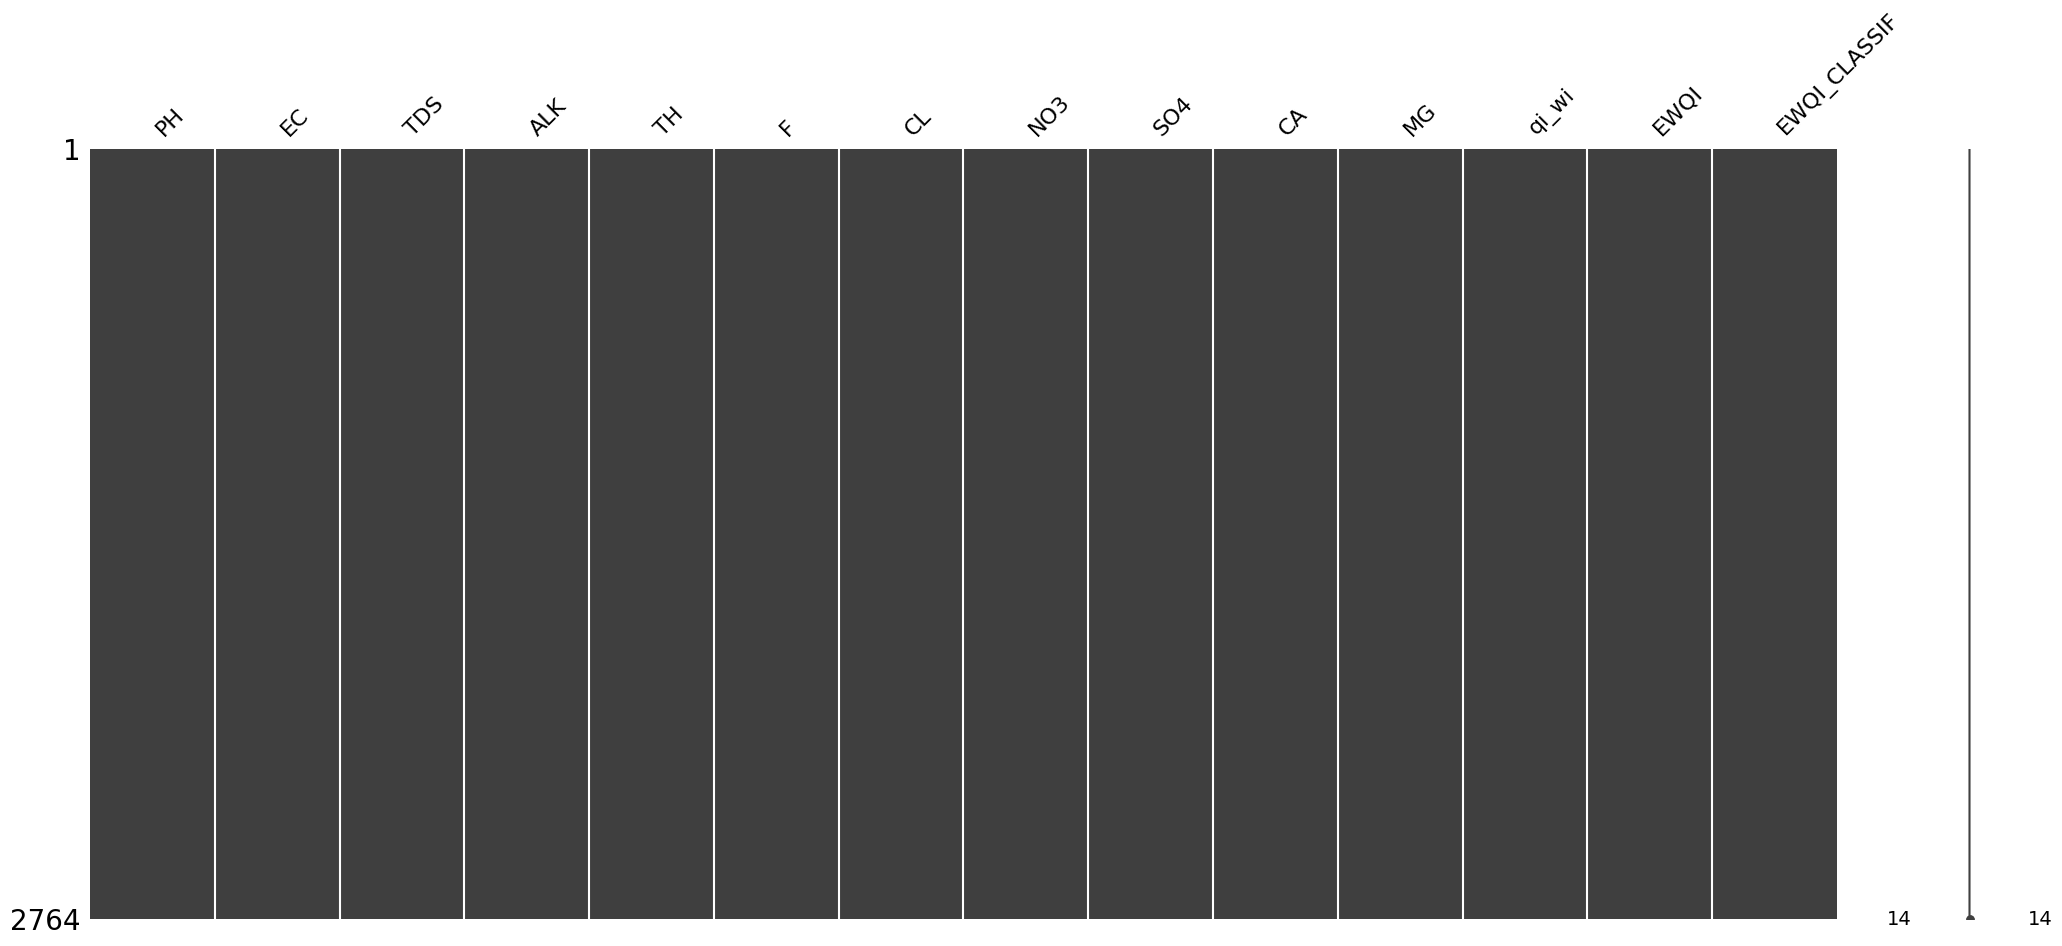

In [6]:
msno.matrix(ewqi_data)

No null values 

Checking for the duplicate data 

In [7]:
ewqi_data.duplicated().sum()

4

In [8]:
duplicated_rows = ewqi_data[ewqi_data.duplicated()]
print(duplicated_rows)

             PH          EC     TDS         ALK          TH          F    CL  \
463   59.333333  432.333333  86.899  216.666667  116.666667  38.666667  68.0   
662   59.333333  432.333333  86.899  216.666667  116.666667  38.666667  68.0   
1066  59.333333  432.333333  86.899  216.666667  116.666667  38.666667  68.0   
1079  59.333333  432.333333  86.899  216.666667  116.666667  38.666667  68.0   

            NO3   SO4         CA          MG       qi_wi        EWQI  \
463   57.777778  24.8  85.333333  136.666667  101.455151  101.455151   
662   57.777778  24.8  85.333333  136.666667  101.455151  101.455151   
1066  57.777778  24.8  85.333333  136.666667  101.455151  101.455151   
1079  57.777778  24.8  85.333333  136.666667  101.455151  101.455151   

     EWQI_CLASSIF  
463    Unsuitable  
662    Unsuitable  
1066   Unsuitable  
1079   Unsuitable  


In [9]:
ewqi_data.drop_duplicates(inplace=True)

In [10]:
ewqi_data.duplicated().sum()

0

In [11]:
import statsmodels.api as sm

X = ewqi_data.drop(['EWQI','EWQI_CLASSIF','qi_wi'], axis=1)
y = ewqi_data['EWQI_CLASSIF']

Checking for the skewness in the data 

In [12]:
X.columns

Index(['PH', 'EC', 'TDS', 'ALK', 'TH', 'F', 'CL', 'NO3', 'SO4', 'CA', 'MG'], dtype='object')

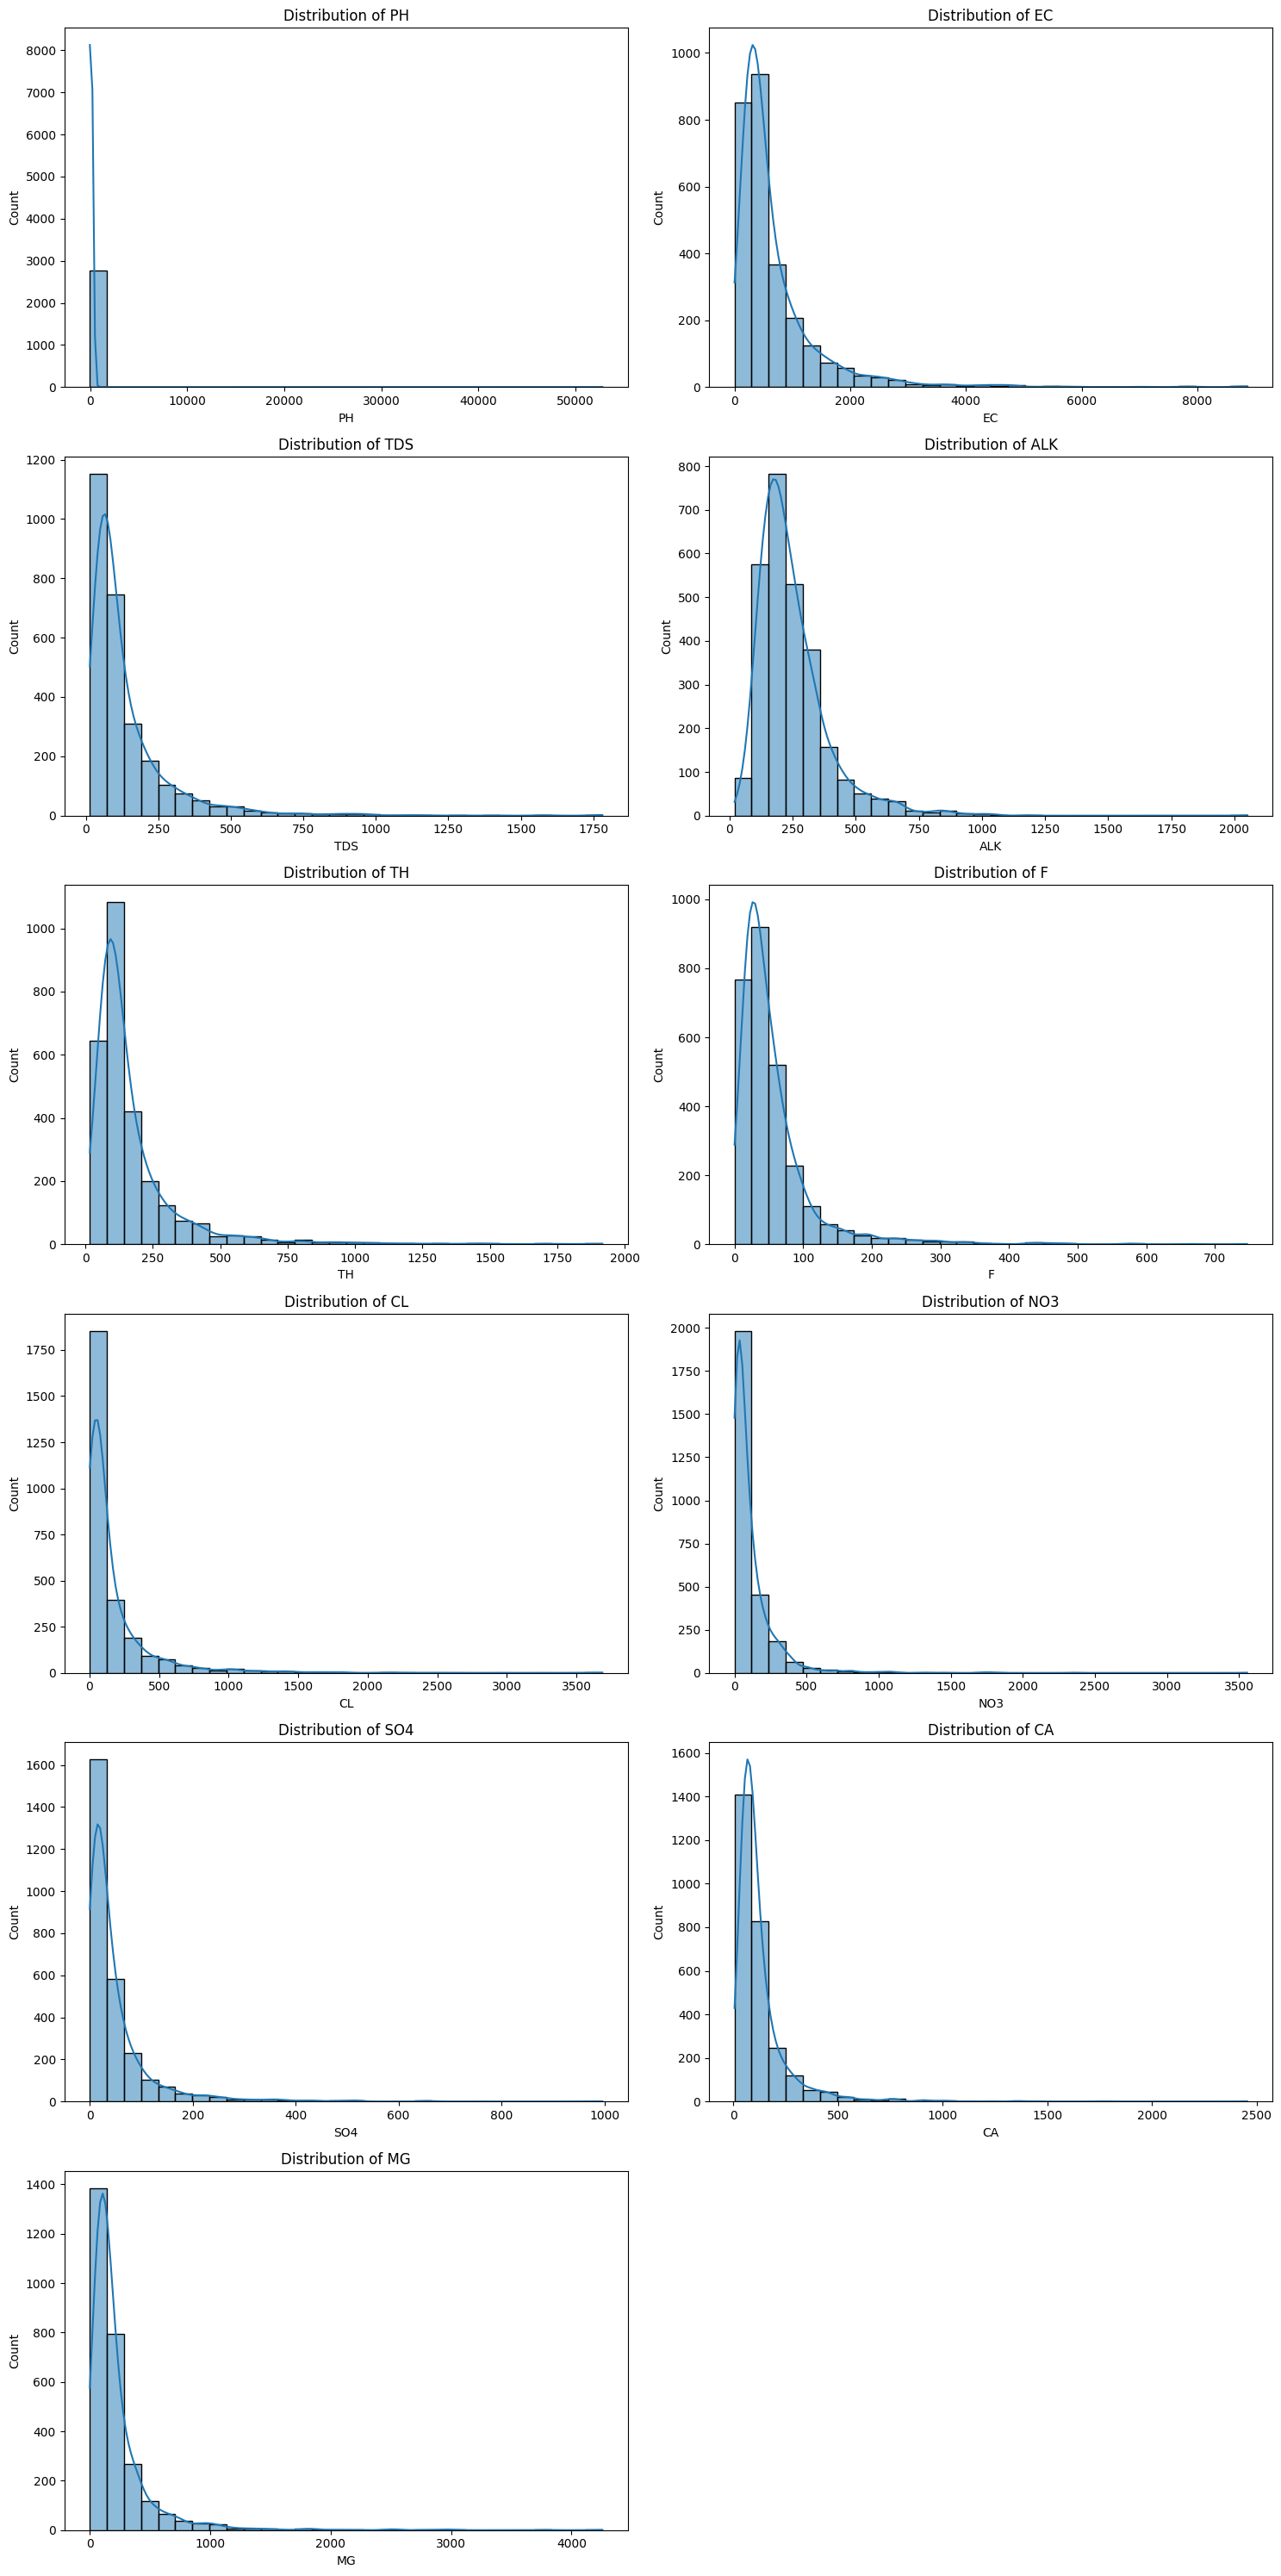

In [13]:
numerical_columns = ['PH', 'EC', 'TDS', 'ALK', 'TH', 'F', 'CL', 'NO3', 'SO4', 'CA', 'MG']

# rows of sub plots 
num_rows = len(numerical_columns) // 2 + len(numerical_columns) % 2

plt.figure(figsize=(15, 5 * num_rows))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 2, i)
    sns.histplot(X[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

In [14]:
X.skew().sort_values(ascending=False)

PH     52.492040
NO3     6.697375
MG      5.237448
CA      5.223159
CL      4.989499
SO4     4.652256
TDS     4.014474
EC      4.012070
TH      4.007648
F       3.990554
ALK     2.453091
dtype: float64

Removing the skewness in the data using the boxcox method as the value for the skewness in the ph column is very high around 50 

In [18]:
import pandas as pd
from scipy import stats

# Assuming numerical_columns is a list of numerical column names in your DataFrame X

for col in numerical_columns:
    # Add a constant to make all values positive
    constant = abs(X[col].min()) + 1  # Adding 1 to ensure all values are positive
    transformed_data, _ = stats.boxcox(X[col] + constant)
    X[col] = transformed_data

# Print DataFrame after transformation
print("DataFrame after Box-Cox transformation:")
print(X)

DataFrame after Box-Cox transformation:
            PH        EC       TDS       ALK        TH         F        CL  \
0     4.502892  6.276852  2.051513  4.413323  1.834351  6.465546  3.666798   
1     4.494664  6.983361  2.107505  4.468108  1.893342  7.804503  4.053162   
2     4.469463  4.796782  1.862717  3.935340  1.780169  3.909695  2.419967   
3     4.477951  6.788949  2.094166  4.457749  1.869460  8.661556  3.966877   
4     4.407419  5.284164  1.934353  3.935340  1.799644  4.072140  2.671969   
...        ...       ...       ...       ...       ...       ...       ...   
2759  4.062926  4.884780  1.876135  3.701040  1.763180  2.636912  2.804473   
2760  4.255978  6.176903  2.041824  4.061966  1.862075  4.654084  3.701959   
2761  4.180475  5.885595  2.010824  3.897113  1.826212  4.891295  3.479403   
2762  4.012254  5.373039  1.946646  4.248306  1.827945  5.044090  2.908477   
2763  4.192554  5.286468  1.934714  3.897113  1.826212  3.552380  3.139451   

            NO3       S

In [19]:
X.skew().sort_values(ascending=False)

TDS    0.070000
CL     0.048435
F      0.036462
TH     0.025223
MG     0.014143
SO4    0.000202
NO3   -0.008483
ALK   -0.009569
CA    -0.010018
EC    -0.041761
PH    -0.344105
dtype: float64

Splitting the data into train and test set 

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Label Encoding the Target Variable 

In [21]:
from sklearn.preprocessing import LabelEncoder

# Label encode categorical features in the training set
le = LabelEncoder()
y_train = le.fit_transform(y_train)

# Label encode categorical features in the test set
y_val = le.transform(y_val)

# Random Forest Classifier

Hyperparameter tuning 

In [23]:
import optuna

def objective(trial):
    
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
    # Create Random Forest classifier with hyperparameters
    rf_clf = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    max_features=max_features,
                                    random_state=42)
    
    # Train the model
    rf_clf.fit(X_train, y_train)
    
    # Predict validation set
    y_pred = rf_clf.predict(X_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    
    return accuracy

# Define study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train model with best parameters
best_rf_clf = RandomForestClassifier(**best_params, random_state=42)
best_rf_clf.fit(X_train, y_train)

# Predict test set
y_pred = best_rf_clf.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

[I 2024-02-01 12:23:33,607] A new study created in memory with name: no-name-b97c0113-d2c8-45e2-b49e-1d8622422524
[I 2024-02-01 12:23:35,328] Trial 0 finished with value: 0.9384057971014492 and parameters: {'n_estimators': 200, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.9384057971014492.
[I 2024-02-01 12:23:36,661] Trial 1 finished with value: 0.9221014492753623 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9384057971014492.
[I 2024-02-01 12:23:43,464] Trial 2 finished with value: 0.9528985507246377 and parameters: {'n_estimators': 800, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.9528985507246377.
[I 2024-02-01 12:23:50,045] Trial 3 finished with value: 0.927536231884058 and parameters: {'n_estimators': 1000, 'max_depth': 6, 'mi

Best Parameters: {'n_estimators': 700, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}
Accuracy: 0.9637681159420289
Confusion Matrix:
[[ 39   0   0   0]
 [  2 102   0   4]
 [  0   1 306   3]
 [  0   9   1  85]]
Classification Report:
              precision    recall  f1-score   support

           1       0.95      1.00      0.97        39
           2       0.91      0.94      0.93       108
           3       1.00      0.99      0.99       310
           4       0.92      0.89      0.91        95

    accuracy                           0.96       552
   macro avg       0.95      0.96      0.95       552
weighted avg       0.96      0.96      0.96       552



Best Parameters: {'n_estimators': 700, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}

Accuracy: 0.9637681159420289

Confusion Matrix:

[[ 39   0   0   0]

 [  2 102   0   4]

 [  0   1 306   3]

 [  0   9   1  85]]

Classification Report:

              precision    recall  f1-score   support

           1       0.95      1.00      0.97        39
           2       0.91      0.94      0.93       108
           3       1.00      0.99      0.99       310
           4       0.92      0.89      0.91        95

    accuracy                           0.96       552

# XGBoost

Hyperparameter tuning 

In [27]:
import optuna
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def objective(trial):
    # Define hyperparameters to tune
    params = {
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),  # Number of unique classes in the target variable
        'eval_metric': 'merror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    }
    
    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    # Train the model
    model = xgb.train(params, dtrain, evals=[(dval, 'eval')], early_stopping_rounds=10, verbose_eval=False)
    
    # Predict validation set
    y_pred = model.predict(dval)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    
    return accuracy

# Define study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train model with best parameters
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predict test set
y_pred = best_model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

[I 2024-02-01 13:32:04,035] A new study created in memory with name: no-name-a24c679d-cad3-4454-afdf-a7f5ff0e3193
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

[13:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.0

[13:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[13:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2024-02-01 13:32:06,178] Trial 4 finished with value: 0.8768115942028986 and parameters: {'booster': 'gbtree', 'lambda': 0.9039745635887146, 'alpha': 0.0002733431259173318, 'max_depth': 14, 'eta': 1.772635653263585e-08, 'gamma': 0.927551778802223, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.9420289855072463.
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),


[13:32:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[13:32:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.0

[13:32:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2024-02-01 13:32:07,121] Trial 10 finished with value: 0.9257246376811594 and parameters: {'booster': 'dart', 'lambda': 0.011985587884995179, 'alpha': 0.5630566298531765, 'max_depth': 1, 'eta': 0.7724030430802661, 'gamma': 0.0006784825869427533, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.9420289855072463.
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:

[13:32:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[13:32:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.0

[13:32:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.0

[13:32:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.0

[13:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.0

[13:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\1537466011.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.0

Best Parameters: {'booster': 'gbtree', 'lambda': 4.0996757817709435e-05, 'alpha': 0.001921434184814864, 'max_depth': 3, 'eta': 0.9783684415003175, 'gamma': 0.05955665353613807, 'grow_policy': 'depthwise'}
Accuracy: 0.9692028985507246
Confusion Matrix:
[[ 38   1   0   0]
 [  1 104   0   3]
 [  0   1 306   3]
 [  0   6   2  87]]
Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.97      0.97        39
           2       0.93      0.96      0.95       108
           3       0.99      0.99      0.99       310
           4       0.94      0.92      0.93        95

    accuracy                           0.97       552
   macro avg       0.96      0.96      0.96       552
weighted avg       0.97      0.97      0.97       552



Best Parameters: {'booster': 'gbtree', 'lambda': 4.0996757817709435e-05, 'alpha': 0.001921434184814864, 'max_depth': 3, 'eta': 0.9783684415003175, 'gamma': 0.05955665353613807, 'grow_policy': 'depthwise'}

Accuracy: 0.9692028985507246

Confusion Matrix:

[[ 38   1   0   0]

 [  1 104   0   3]

 [  0   1 306   3]

 [  0   6   2  87]]

Classification Report:

              precision    recall  f1-score   support

           1       0.97      0.97      0.97        39
           2       0.93      0.96      0.95       108
           3       0.99      0.99      0.99       310
           4       0.94      0.92      0.93        95

    accuracy                           0.97       552
   macro avg       0.96      0.96      0.96       552
weighted avg       0.97      0.97      0.97       552

# LightGBM

Hyperparameter tuning 

In [24]:
import optuna
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def objective(trial):
    
    # Define hyperparameters to tune
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'num_class': len(np.unique(y_train)),  # Number of unique classes in the target variable
        'random_state': 42
    }
    
    # Create LightGBM classifier with hyperparameters
    lgb_clf = lgb.LGBMClassifier(**params)
    
    # Train the model
    lgb_clf.fit(X_train, y_train)
    
    # Predict validation set
    y_pred = lgb_clf.predict(X_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    
    return accuracy

# Define study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train model with best parameters
best_lgb_clf = lgb.LGBMClassifier(**best_params, random_state=42)
best_lgb_clf.fit(X_train, y_train)

# Predict test set
y_pred = best_lgb_clf.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

[I 2024-02-01 12:35:54,020] A new study created in memory with name: no-name-89c07339-18df-4423-bdea-67cf5f75e5f5
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\667253574.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\667253574.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\667253574.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/

Best Parameters: {'lambda_l1': 0.0011661319863511383, 'lambda_l2': 1.6684278485022657e-07, 'num_leaves': 161, 'max_depth': 7, 'learning_rate': 0.3670916064166401, 'feature_fraction': 0.4438919262508763, 'bagging_fraction': 0.9321329525746214, 'bagging_freq': 4, 'min_child_samples': 92}
[LightGBM] [Warning] feature_fraction is set=0.4438919262508763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4438919262508763
[LightGBM] [Warning] lambda_l1 is set=0.0011661319863511383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011661319863511383
[LightGBM] [Warning] lambda_l2 is set=1.6684278485022657e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6684278485022657e-07
[LightGBM] [Warning] bagging_fraction is set=0.9321329525746214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9321329525746214
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] fe

Best Parameters: {'lambda_l1': 0.0011661319863511383, 'lambda_l2': 1.6684278485022657e-07, 'num_leaves': 161, 'max_depth': 7, 'learning_rate': 0.3670916064166401, 'feature_fraction': 0.4438919262508763, 'bagging_fraction': 0.9321329525746214, 'bagging_freq': 4, 'min_child_samples': 92}

Accuracy: 0.9746376811594203

Confusion Matrix:

[[ 38   1   0   0]

 [  1 104   0   3]

 [  0   1 307   2]

 [  0   5   1  89]]

Classification Report:

              precision    recall  f1-score   support

           1       0.97      0.97      0.97        39
           2       0.94      0.96      0.95       108
           3       1.00      0.99      0.99       310
           4       0.95      0.94      0.94        95

    accuracy                           0.97       552

# CatBoost 

Hyperparameter tuning 

In [25]:
import optuna
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def objective(trial):
    
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
    }
    
    # Create CatBoost classifier with hyperparameters
    catboost_clf = CatBoostClassifier(**params, random_state=42, verbose=False)
    
    # Train the model
    catboost_clf.fit(X_train, y_train)
    
    # Predict validation set
    y_pred = catboost_clf.predict(X_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    
    return accuracy

# Define study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train model with best parameters
best_catboost_clf = CatBoostClassifier(**best_params, random_state=42, verbose=False)
best_catboost_clf.fit(X_train, y_train)

# Predict test set
y_pred = best_catboost_clf.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

[I 2024-02-01 12:36:15,571] A new study created in memory with name: no-name-1fcfe87c-1362-43b3-9e1f-5eb1d0edf053
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\2917534988.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2024-02-01 12:36:17,493] Trial 0 finished with value: 0.9492753623188406 and parameters: {'n_estimators': 300, 'learning_rate': 0.07252190405685235, 'max_depth': 6, 'colsample_bylevel': 0.10186722048052338, 'bagging_temperature': 8.938379720543884, 'random_strength': 0.8680998714911226}. Best is trial 0 with value: 0.9492753623188406.
C:\Users\Smit Raval\AppData\Local\Temp\ipykernel_27720\2917534988.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://githu

Best Parameters: {'n_estimators': 900, 'learning_rate': 0.04986786370169693, 'max_depth': 8, 'colsample_bylevel': 0.7204832069207197, 'bagging_temperature': 1.1242603701897533, 'random_strength': 9.166316049551888}
Accuracy: 0.9855072463768116
Confusion Matrix:
[[ 38   1   0   0]
 [  0 108   0   0]
 [  0   1 308   1]
 [  0   5   0  90]]
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.97      0.99        39
           2       0.94      1.00      0.97       108
           3       1.00      0.99      1.00       310
           4       0.99      0.95      0.97        95

    accuracy                           0.99       552
   macro avg       0.98      0.98      0.98       552
weighted avg       0.99      0.99      0.99       552



Best Parameters: {'n_estimators': 900, 'learning_rate': 0.04986786370169693, 'max_depth': 8, 'colsample_bylevel': 0.7204832069207197, 'bagging_temperature': 1.1242603701897533, 'random_strength': 9.166316049551888}

Accuracy: 0.9855072463768116

Confusion Matrix:

[[ 38   1   0   0]

 [  0 108   0   0]

 [  0   1 308   1]

 [  0   5   0  90]]

Classification Report:

              precision    recall  f1-score   support

           1       1.00      0.97      0.99        39
           2       0.94      1.00      0.97       108
           3       1.00      0.99      1.00       310
           4       0.99      0.95      0.97        95

    accuracy                           0.99       552

# Voting Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

params1 = {'n_estimators': 700, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}
params2 = {'booster': 'gbtree', 'lambda': 4.0996757817709435e-05, 'alpha': 0.001921434184814864, 'max_depth': 3, 'eta': 0.9783684415003175, 'gamma': 0.05955665353613807, 'grow_policy': 'depthwise'}
params3 = {'lambda_l1': 0.0011661319863511383, 'lambda_l2': 1.6684278485022657e-07, 'num_leaves': 161, 'max_depth': 7, 'learning_rate': 0.3670916064166401, 'feature_fraction': 0.4438919262508763, 'bagging_fraction': 0.9321329525746214, 'bagging_freq': 4, 'min_child_samples': 92}
params4 = {'n_estimators': 900, 'learning_rate': 0.04986786370169693, 'max_depth': 8, 'colsample_bylevel': 0.7204832069207197, 'bagging_temperature': 1.1242603701897533, 'random_strength': 9.166316049551888}
# Initialize individual models
model1 = RandomForestClassifier(**params1, random_state=42)
model2 = XGBClassifier(**params2, random_state=42)
model3 = LGBMClassifier(**params3, random_state=42)
model4 = CatBoostClassifier(**params4, random_state=42)

In [29]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import VotingClassifier

# Assuming you have already defined and trained your individual models (model1, model2, model3, model4)

# Create voting classifier with hard voting
voting_clf = VotingClassifier(estimators=[('rfc', model1), ('xgb', model2), ('lgb', model3), ('cat', model4)], voting='hard')

# Fit the voting classifier on the training data
voting_clf.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.4438919262508763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4438919262508763
[LightGBM] [Warning] lambda_l1 is set=0.0011661319863511383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011661319863511383
[LightGBM] [Warning] lambda_l2 is set=1.6684278485022657e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6684278485022657e-07
[LightGBM] [Warning] bagging_fraction is set=0.9321329525746214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9321329525746214
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4438919262508763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4438919262508763
[LightGBM] [Warning] lambda_l1 is set=0.0011661319863511383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011661319863511383
[LightGBM] [Warni

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(max_depth=15,
                                                     max_features='log2',
                                                     min_samples_split=3,
                                                     n_estimators=700,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(alpha=0.001921434184814864,
                                            base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_catego...
                                            n_estimators=100, n_jobs=None, ...)),
                             ('lgb',
                              LGBMClassifier(bagging_fraction=0.9321329525746214,
                                             bagging_freq=4,
                                             feature_fraction=0.4438919262508763,
                                             lambda_l1=0.0011661319863511383,
                                             lambda_l2=1.6684278485022657e-07,
                                             learning_rate=0.3670916064166401,
                                             max_depth=7, min_child_samples=92,
                                             num_leaves=161, random_state=42)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x000001B280985F50>)])

In [31]:
# Predict on the validation set

y_pred = voting_clf.predict(X_val)

[LightGBM] [Warning] feature_fraction is set=0.4438919262508763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4438919262508763
[LightGBM] [Warning] lambda_l1 is set=0.0011661319863511383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011661319863511383
[LightGBM] [Warning] lambda_l2 is set=1.6684278485022657e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6684278485022657e-07
[LightGBM] [Warning] bagging_fraction is set=0.9321329525746214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9321329525746214
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4, 552) + inhomogeneous part.